In [50]:
with open('data/VISAP.md', 'r') as f: md = f.read()
pages = md.split("\n") # Split in pages

print(f"The number of elements is {len(pages)}")

The number of elements is 26


In [51]:

# --- 2) Lightweight NLP: noun/proper-noun lemmas only ---
nlp = spacy.load("en_core_web_sm", disable=["parser","ner","textcat"])  # 'md' is lighter than 'lg'

custom_stop = {}

docs = list(nlp.pipe(pages, batch_size=50, n_process=2))

def doc_to_terms(doc):
    out = []
    for tok in doc:
        if tok.is_alpha and tok.pos_ in {"NOUN","PROPN"}:
            lemma = tok.lemma_.lower()
            if len(lemma) > 2 and lemma not in custom_stop:
                out.append(lemma)
    return out

tokenized = [doc_to_terms(d) for d in docs]
texts = [" ".join(toks) for toks in tokenized]  # pre-tokenized → string for vectorizer

# --- 3) TF-IDF matrix ---
tfidf = TfidfVectorizer(min_df=2, max_df=0.9, ngram_range=(1,1), dtype=np.float32)
X = tfidf.fit_transform(texts)
print(f"TF-IDF shape: {X.shape}")

TF-IDF shape: (26, 252)


UMAP embedding shape: (26, 2)


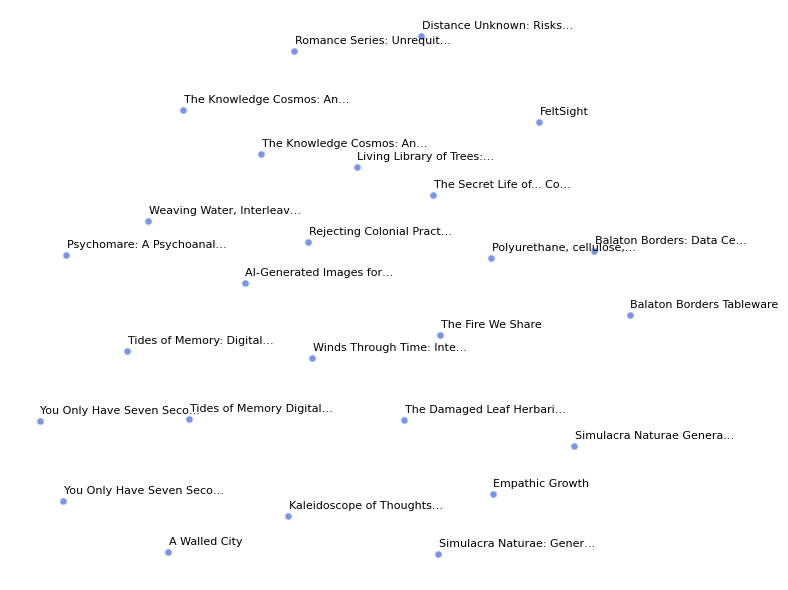

In [57]:
import re
import matplotlib.pyplot as plt

# Extract labels between ** ** and limit their length
max_len = 25  # adjust this as you like

labels = []
for i, text in enumerate(pages):
    m = re.match(r'^\*\*(.+?)\*\*', text)
    if m:
        label = m.group(1).strip()
        if len(label) > max_len:
            label = label[:max_len - 1].rstrip() + "…"
    else:
        label = str(i + 1)
    labels.append(label)

# Compute UMAP
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)
emb = reducer.fit_transform(X)
print("UMAP embedding shape:", emb.shape)

# Draw
plt.figure(figsize=(8, 6))
plt.scatter(emb[:, 0], emb[:, 1], s=30, c='royalblue', alpha=0.7, edgecolors='white')

for i, label in enumerate(labels):
    plt.text(emb[i, 0] + 0.005, emb[i, 1] + 0.04, label, fontsize=8, color='black')

plt.axis('off')
plt.tight_layout()
plt.show()